# Analysis of the London Rental Property Market
#### Toby Petty - 11 March 2018
Analysis of the London rental property market by using all rental listings added to <a href="http://www.rightmove.co.uk" _target="blank">rightmove</a> in the last 24 hours.

In [1]:
# Imports:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rightmove_webscraper
import numpy as np
%matplotlib inline

# URL for all London properties to rent, added in last 24hrs:
url = "http://www.rightmove.co.uk/property-to-rent/find.html?searchType=RENT&\
locationIdentifier=REGION%5E87490&insId=1&radius=0.0&minPrice=&maxPrice=&\
minBedrooms=&maxBedrooms=&displayPropertyType=&maxDaysSinceAdded=1&\
sortByPriceDescending=&_includeLetAgreed=on&primaryDisplayPropertyType=&\
secondaryDisplayPropertyType=&oldDisplayPropertyType=&\
oldPrimaryDisplayPropertyType=&letType=&letFurnishType=&houseFlatShare="

# Scrape rightmove:
rightmove_data = rightmove_webscraper.rightmove_data(url)

# Create DataFrame of results:
df = rightmove_data.get_results

### How many listings are there for each type of apartment?
E.g. Studios, 1-beds, 2-beds etc.

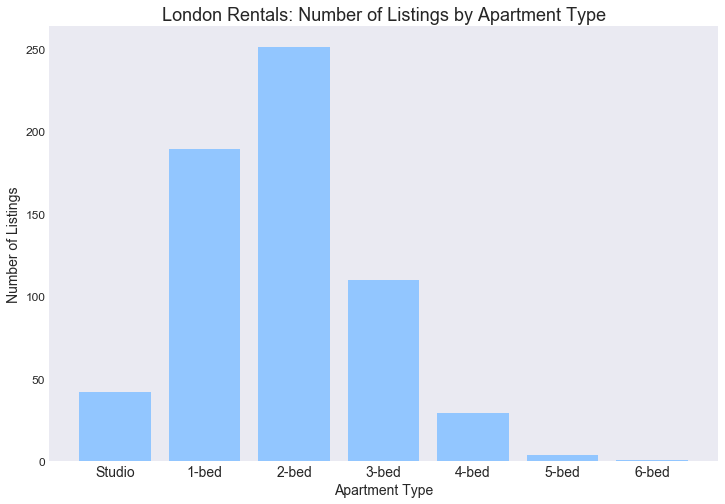

In [2]:
def plot_by_type(rightmove_data):
    
    # The .summary() method summarises the results by number of bedrooms:
    df = rightmove_data.summary()
    
    labels = [i + "-bed" if i != 0 else "Studio" for i in df["number_bedrooms"]]
    x = df.index
    y = df["count"]
    sns.set_style("dark")
    sns.set_palette(sns.color_palette("pastel"))
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.title("London Rentals: Number of Listings by Apartment Type", size = 18)
    plt.xlabel("Apartment Type", size = 14)
    plt.ylabel("Number of Listings", size = 14)
    plt.xticks(size = 14)
    plt.yticks(size = 12)
    plt.bar(x, y, tick_label=labels)
    plt.show()

plot_by_type(rightmove_data)

## Which postcode areas have the most listings?

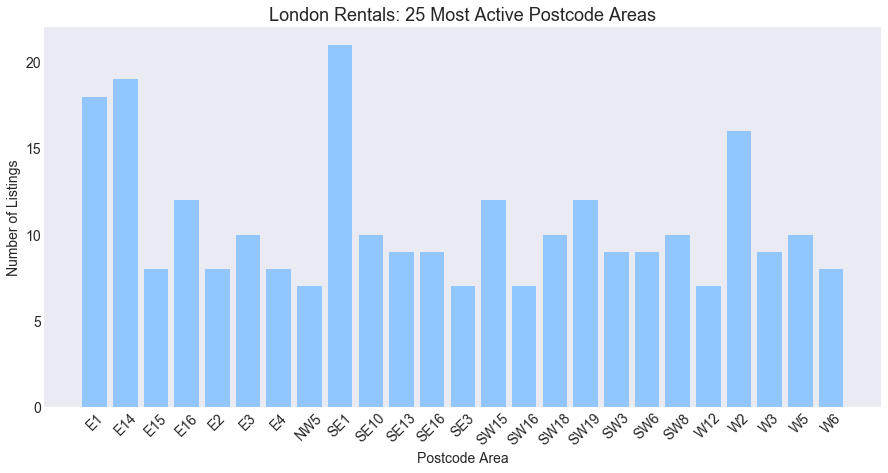

In [3]:
def plot_by_postcode(rightmove_data, number_to_plot = 25):
    
    # The .summary() method summarises the results by number of bedrooms:
    df = rightmove_data.summary("postcode")\
    .sort_values(by = "count", ascending = False)\
    .reset_index(drop = True)[:number_to_plot]

    x = df["postcode"]
    y = df["count"]
    ymax = ((df["count"].max() // 5) + 1) * 5
    
    sns.set_palette(sns.color_palette("pastel"))
    fig, ax = plt.subplots(figsize=(15, 7))
    plt.title("London Rentals: {} Most Active Postcode Areas".format(number_to_plot), size = 18)
    plt.xlabel("Postcode Area", size = 14)
    plt.ylabel("Number of Listings", size = 14)
    plt.xticks(rotation = 45, size = 14)
    plt.yticks(range(0, ymax, 5), size = 14)
    plt.bar(x, y)
    plt.show()

plot_by_postcode(rightmove_data, number_to_plot = 25)

## What are the average prices and number of listings in each London borough?

In [10]:
def add_borough(df, postcodes_df):
    """Add the borough column based on lookup table using data 
    from https://www.doogal.co.uk/PostcodeDownloads.php."""

    # Useful columns are Postcode and District, so drop the rest:
    cols_to_drop = postcodes_df.columns.drop(["Postcode", "District"])
    postcodes_df.drop(labels = cols_to_drop, axis = 1, inplace = True)

    # Only need the stem of the postcode (e.g. from "N1 6RQ": "N1"):
    postcodes_df["stem"] = postcodes_df["Postcode"].str.split(" ").str.get(0)

    # Drop duplicate rows and reset index:
    postcodes_df.drop_duplicates(inplace = True)
    postcodes_df.reset_index(drop = True, inplace = True)

    # Some postcodes cross multiple districts, e.g. N1 is in Hackney 
    # and Islington. To deal with this take a pivot table of postcode
    # by District, and keep the District with the maximum count.

    # Create pivot table of postcode stem by how many postcodes in each District:
    pivot = pd.DataFrame(pd.pivot_table(postcodes_df, values = "Postcode",index = "stem",
                                        columns = "District", aggfunc = "count"))

    # Keep max District count for each postcode_stem:
    lookup = pd.DataFrame(pivot.idxmax(axis = 1))
    lookup.reset_index(inplace = True)

    # Rename columns:
    lookup.rename(columns = {"stem":"postcode", 0:"borough"}, inplace = True)
    
    # Merge the borough column into main DataFrame:
    df = pd.merge(left = df, right = lookup, how = "left", 
                  left_on = "postcode", right_on = "postcode")
    
    return df

def add_inner_outer(df):
    """Adds a classification column of inner/outer London based on borough."""
    io_london = pd.read_csv("./inner_outer_london.csv", header = None)
    io_london.rename(columns = {0:"borough", 1:"inner_outer"}, inplace = True)
    out_df = pd.merge(left = df, right = io_london, how = "left",
                      left_on = "borough", right_on = "borough")
    return out_df

def remove_null_rows(df, col):
    out_df = df[df[col].notnull()]
    out_df.reset_index(inplace = True, drop = True)
    return out_df

def summary_df(df, col_to_group, col_to_summarise):
    """Create a summary of the df by col."""
    
    groupers = {col_to_summarise:["count", "mean"]}
    out_df = df.groupby(df[col_to_group]).agg(groupers).astype(int)
    out_df.columns = out_df.columns.get_level_values(1)
    out_df.reset_index(inplace = True)
    out_df = add_inner_outer(out_df)
    # Drop any non-London postcodes that have snuck in there:
    out_df.dropna(subset=["inner_outer"], inplace = True)
    out_df.reset_index(inplace = True, drop = True)
    return out_df

def good_axis_max(axis_max):
    """Helper function for charts to provide aesthtically pleasing axis."""
    magnitude = 10**(len(str(axis_max))-1)
    max_axis = ((axis_max // magnitude) + 1) * magnitude
    return max_axis

def good_axis_min(axis_min):
    """Helper function for charts to provide aesthtically pleasing axis."""
    magnitude = 10**(len(str(axis_min))-1)
    min_axis = (((axis_min) // magnitude)) * magnitude
    if axis_min == min_axis and axis_min > 0:
        min_axis -= magnitude
    return min_axis

def borough_scatterplot(df, x, y, labels, title, xlabel, ylabel, hue, size=7, aspect=1.2):
    """Create a scatter plot of price & number of listings by borough."""
    
    df.sort_values(by = ["mean", "count"])
    df.reset_index(inplace = True, drop = True)
    
    sns.set_style("white")
    scatter = sns.lmplot(x = x, y = y, data = df, fit_reg = False, hue = hue,
                         palette = sns.color_palette("bright"),
                         legend=False, size = size, aspect = aspect)

    scatter.set(xlim = (good_axis_min(df[x].min()), good_axis_max(df[x].max()) + 0.1), 
                        ylim = (good_axis_min(df[y].min()), good_axis_max(df[y].max())))
        
    # Add data labels:
    style = dict(size=10, color='gray')
    for r in range(len(df)):
        x = df.loc[r, "count"]
        y = df.loc[r, "mean"]
        label = df.loc[r, "borough"]
        scatter.ax.text(x, y, label, **style)

    plt.title(title, size=14)
    plt.legend(loc = "upper right", bbox_to_anchor=(1.2, 1), fontsize = "xx-large", )
    plt.xlabel(xlabel, size=14)
    plt.ylabel(ylabel, size=14)
    plt.xticks(size = 14)
    plt.yticks(size = 14)
    plt.show()

First off for all types of apartment:

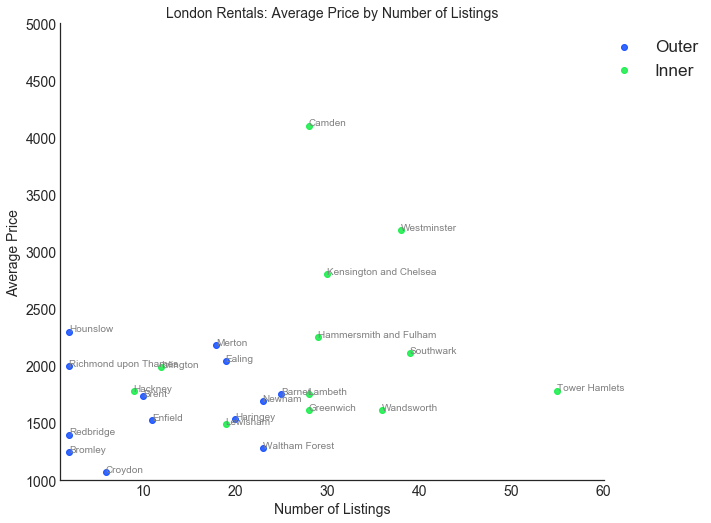

In [11]:
# File to use to add in borough data:
postcodes_df = pd.read_csv("./postcodes.csv", low_memory = False)

price_by_borough_df = summary_df(remove_null_rows(add_inner_outer(add_borough(df, postcodes_df)), "borough"), col_to_group = "borough", col_to_summarise = "price")

borough_scatterplot(price_by_borough_df, "count", "mean", "borough",
                    "London Rentals: Average Price by Number of Listings",
                    "Number of Listings", "Average Price", "inner_outer")

Next just for one-beds:

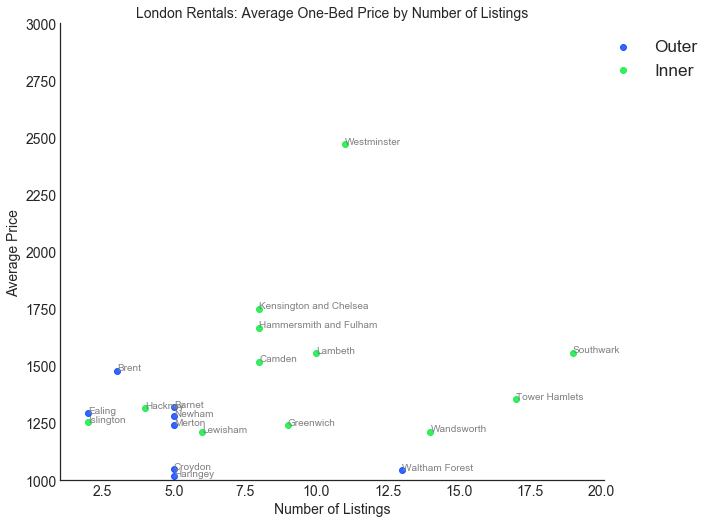

In [12]:
one_beds = df[df["number_bedrooms"]=="1"]
one_beds_borough_df = summary_df(remove_null_rows(add_inner_outer(add_borough(one_beds, postcodes_df)), "borough"),
                                 col_to_group = "borough", col_to_summarise = "price")

borough_scatterplot(one_beds_borough_df, "count", "mean", "borough",
                    "London Rentals: Average One-Bed Price by Number of Listings",
                    "Number of Listings", "Average Price", "inner_outer")

Wandsworth and Tower Hamlets look like cheaper inner-London boroughs with plentiful listings ...
## Find some promising listings

In [13]:
def cheap_listings(rightmove_data, postcodes_df, boroughs = [], number=10):
    df = rightmove_data.get_results
    df = add_borough(df, postcodes_df)
    df = df[df["borough"].isin(boroughs)]
    df.sort_values(by = "price", ascending = True, inplace = True)
    df.reset_index(inplace = True, drop = True)
    for l in range(number):
        print("£{} - {} - {}" .format(df.loc[l, "price"], df.loc[l, "borough"], df.loc[l, "url"]))
        
cheap_listings(rightmove_data, postcodes_df, boroughs = ["Wandsworth", "Tower Hamlets"], number = 10)

£650 - Tower Hamlets - http://www.rightmove.co.uk/property-to-rent/property-64439227.html
£672 - Tower Hamlets - http://www.rightmove.co.uk/property-to-rent/property-71912681.html
£700 - Wandsworth - http://www.rightmove.co.uk/property-to-rent/property-71911172.html
£700 - Wandsworth - http://www.rightmove.co.uk/property-to-rent/property-71911220.html
£700 - Wandsworth - http://www.rightmove.co.uk/property-to-rent/property-71911277.html
£725 - Tower Hamlets - http://www.rightmove.co.uk/property-to-rent/property-51724320.html
£725 - Tower Hamlets - http://www.rightmove.co.uk/property-to-rent/property-51724320.html
£750 - Tower Hamlets - http://www.rightmove.co.uk/property-to-rent/property-64439221.html
£750 - Tower Hamlets - http://www.rightmove.co.uk/property-to-rent/property-64439224.html
£750 - Wandsworth - http://www.rightmove.co.uk/property-to-rent/property-71911103.html
